In [1]:
from pathlib import Path
import pandas as pd

METADATA_CSV = Path("ATEPP-master/ATEPP-metadata-1.2.csv")
MIDI_ROOT = Path("ATEPP-1.2/ATEPP-1.2")
SCORE_ROOT = MIDI_ROOT
QUALITY_EXCLUDE = {"low quality", "background noise", "applause", "corrupted"}

def has_nonempty(v) -> bool:
    return isinstance(v, str) and v.strip() != ""

df = pd.read_csv(METADATA_CSV)
df["quality"] = df.get("quality", "").fillna("").str.lower()

mask_score = df["score_path"].apply(has_nonempty)
mask_quality = ~df["quality"].isin(QUALITY_EXCLUDE)
df = df[mask_score & mask_quality].copy()

df["midi_abs"] = df["midi_path"].apply(lambda p: str((MIDI_ROOT / str(p)).resolve()))
df["score_abs"] = df["score_path"].apply(lambda p: str((SCORE_ROOT / str(p)).resolve()))
df["midi_exists"] = df["midi_abs"].apply(lambda p: Path(p).exists())
df["score_exists"] = df["score_abs"].apply(lambda p: Path(p).exists())

usable = df[df["midi_exists"] & df["score_exists"]].copy()
out_csv = METADATA_CSV.parent / "usable_with_scores_v1.2.csv"
usable.to_csv(out_csv, index=False)

print(f"Total rows: {len(pd.read_csv(METADATA_CSV))}")
print(f"After score+quality filter: {len(df)}")
print(f"After file existence check: {len(usable)}")
print(f"Saved to: {out_csv}")


Total rows: 11674
After score+quality filter: 3734
After file existence check: 3734
Saved to: ATEPP-master/usable_with_scores_v1.2.csv


In [2]:
import pandas as pd

csv_path = "ATEPP-master/usable_with_scores_v1.2.csv"
df = pd.read_csv(csv_path)

print("rows:", len(df))
print(df[["artist", "track", "midi_abs", "score_abs"]].head())

# 抽几条检查路径是否存在
sample = df.sample(n=5, random_state=42)[["midi_abs", "score_abs"]]
sample["midi_exists"] = sample["midi_abs"].apply(lambda p: Path(p).exists())
sample["score_exists"] = sample["score_abs"].apply(lambda p: Path(p).exists())
print(sample)


rows: 3734
               artist                                              track  \
0  Sviatoslav Richter  13 Preludes, Op. 32: No. 12 in G-Sharp Minor: ...   
1  Sviatoslav Richter  13 Preludes, Op. 32: No. 12 in G-Sharp Minor: ...   
2   Vladimir Horowitz       13 Preludes, Op. 32: No. 12 in G-Sharp Minor   
3   Vladimir Horowitz       13 Preludes, Op. 32: No. 12 in G-Sharp Minor   
4   Vladimir Horowitz       13 Preludes, Op. 32: No. 12 in G-Sharp Minor   

                                            midi_abs  \
0  /Users/toddywang/Documents/VsCodeProjects/xmlt...   
1  /Users/toddywang/Documents/VsCodeProjects/xmlt...   
2  /Users/toddywang/Documents/VsCodeProjects/xmlt...   
3  /Users/toddywang/Documents/VsCodeProjects/xmlt...   
4  /Users/toddywang/Documents/VsCodeProjects/xmlt...   

                                           score_abs  
0  /Users/toddywang/Documents/VsCodeProjects/xmlt...  
1  /Users/toddywang/Documents/VsCodeProjects/xmlt...  
2  /Users/toddywang/Documents/

In [7]:
from pathlib import Path
import warnings
import pandas as pd
import partitura as pt

warnings.filterwarnings("ignore", category=UserWarning, module="partitura")

df = pd.read_csv("ATEPP-master/usable_with_scores_v1.2.csv")
row = df.iloc[0]
print("metadata row:")
print(row)

score_xml = Path(row["score_abs"])
perf_midi = Path(row["midi_abs"])
print("\nscore exists:", score_xml.exists(), "midi exists:", perf_midi.exists())

score_notes = pt.load_score(str(score_xml))[0].note_array()
perf_notes = pt.load_performance_midi(str(perf_midi))[0].note_array()

# 只展示字段名和前 5 行
print("\nscore note_array fields:", score_notes.dtype.names)
print(pd.DataFrame(score_notes[:5]))

print("\nperf note_array fields:", perf_notes.dtype.names)
print(pd.DataFrame(perf_notes[:5]))


metadata row:
artist                                           Sviatoslav Richter
artist_id                                                         0
track             13 Preludes, Op. 32: No. 12 in G-Sharp Minor: ...
track_duration                                              141.666
composer                                        Sergei Rachmaninoff
composition_id                                                    7
score_path        Sergei_Rachmaninoff/13_Preludes,_Op._32/No._12...
midi_path         Sergei_Rachmaninoff/13_Preludes,_Op._32/No._12...
youtube_links           https://www.youtube.com/watch?v=p1asYfE4IcY
quality                                                         NaN
perf_id                                                          25
album                              The Legendary 1958 Sofia Recital
album_date                                               2013-03-01
repetition                                                      NaN
midi_abs          /Users/toddywang

In [12]:
from pathlib import Path
import warnings, numpy as np, pandas as pd, partitura as pt

warnings.filterwarnings("ignore", category=UserWarning, module="partitura")

df = pd.read_csv("ATEPP-master/usable_with_scores_v1.2.csv")
i = 0  # 想换样本改这里
score_xml = Path(df.loc[i, "score_abs"])
print("score exists:", score_xml.exists())

score_notes = pt.load_score(str(score_xml))[0].note_array()

onsets = score_notes["onset_beat"]
durs = score_notes["duration_beat"]
ends = onsets + durs

total_beats_span = np.ceil(ends.max() - onsets.min())
unique_onsets = len(np.unique(onsets))

print(f"拍子跨度（ceil）：{total_beats_span} 拍")
print(f"唯一起拍数（有多少个起点）：{unique_onsets}")


score exists: True
拍子跨度（ceil）：565.0 拍
唯一起拍数（有多少个起点）：1066


In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
import re

work_dir = Path("AlignmentTool/work")
match_path = work_dir / "perf_match.txt"
fmt3x_path = work_dir / "score_fmt3x.txt"

# 1) 读 TPQN（乐谱 tick 每四分拍）
tpqn = 24  # 默认
m = re.search(r"TPQN:\s*(\d+)", fmt3x_path.read_text())
if m:
    tpqn = float(m.group(1))
print("TPQN:", tpqn)

# 2) 解析 match 文件（跳过注释/Missing）
rows = []
for ln in match_path.read_text().splitlines():
    if not ln.strip() or ln.startswith("//") or ln.startswith("Missing"):
        continue
    parts = re.split(r"\s+", ln.strip())
    if len(parts) < 12:
        continue
    rows.append({
        "id": int(parts[0]),
        "onset": float(parts[1]),
        "offset": float(parts[2]),
        "pitch": parts[3],
        "pitch_int": int(parts[4]),
        "vel_on": int(parts[5]),
        "channel": int(parts[6]),
        "match_status": int(parts[7]),
        "score_time": float(parts[8]),
        "score_note": parts[9],
        "err_idx": parts[10],
        "skip_idx": parts[11],
    })
df = pd.DataFrame(rows)
df["score_beat"] = df["score_time"] / tpqn

print("总音符:", len(df))
print("err_idx 分布:\n", df["err_idx"].value_counts())

# 3) 只保留正常匹配（可按需放宽/收紧）
mask = (df["score_note"] != "*") & (df["err_idx"] == "0")
df_ok = df[mask]

# 4) 乐谱拍 -> 演奏时间：按 score_beat 聚合，取中位 onset
group = df_ok.groupby("score_beat")["onset"].median().sort_index()
aligned_beats = group.index.to_numpy()
aligned_times = group.values

# 5) 计算 BPM：60 * Δbeat / Δt，过滤极小 Δt
if len(aligned_times) > 1:
    d_beat = np.diff(aligned_beats)
    d_time = np.diff(aligned_times)
    mask_dt = d_time > 0.05  # 去掉 <50ms 的间隔
    tempo = 60.0 * d_beat[mask_dt] / d_time[mask_dt]
    tempo = tempo[(tempo > 30) & (tempo < 300)]  # 合理范围，可调整
    print("有效间隔数:", len(tempo))
    print("BPM 统计: min={:.1f} med={:.1f} max={:.1f}".format(tempo.min(), np.median(tempo), tempo.max()))
    print("BPM 前 10:", tempo[:10])
else:
    print("对齐结果过短，无法计算 BPM")

TPQN: 480.0
总音符: 1730
err_idx 分布:
 err_idx
0    1466
3     218
1      46
Name: count, dtype: int64
有效间隔数: 972
BPM 统计: min=31.9 med=157.8 max=299.2
BPM 前 10: [125.21808817 174.54443901 153.60039322 230.40058983 182.85770014
 160.         188.85265716 185.80453363 171.94144821 188.85265716]


In [17]:
from pathlib import Path
import pandas as pd
import numpy as np
import re

def bpm_per_beat(match_path: Path, fmt3x_path: Path, dt_min=0.05, bpm_range=(30,300)):
    tpqn = 24.0
    m = re.search(r"TPQN:\s*(\d+)", fmt3x_path.read_text())
    if m:
        tpqn = float(m.group(1))

    rows = []
    for ln in match_path.read_text().splitlines():
        if not ln.strip() or ln.startswith("//") or ln.startswith("Missing"):
            continue
        parts = re.split(r"\s+", ln.strip())
        if len(parts) < 12:
            continue
        rows.append({
            "onset": float(parts[1]),
            "score_time": float(parts[8]),
            "score_note": parts[9],
            "err_idx": parts[10],
        })
    if not rows:
        return {"tpqn": tpqn, "valid": False}

    df = pd.DataFrame(rows)
    df["score_beat"] = df["score_time"] / tpqn
    # 只保留正常匹配
    df = df[(df["score_note"] != "*") & (df["err_idx"] == "0")]
    if df.empty:
        return {"tpqn": tpqn, "valid": False}

    # 按整拍分桶：四舍五入到最近的整数拍
    df["beat_bin"] = df["score_beat"].round()
    group = df.groupby("beat_bin")["onset"].median().sort_index()
    beats = group.index.to_numpy()
    times = group.values
    if len(times) < 2:
        return {"tpqn": tpqn, "valid": False}

    d_beat = np.diff(beats)    # 应该大多为 1 拍
    d_time = np.diff(times)
    mask = (d_time > dt_min) & (d_beat > 1e-6)
    tempo = 60.0 * d_beat[mask] / d_time[mask]
    lo, hi = bpm_range
    tempo = tempo[(tempo > lo) & (tempo < hi)]
    if len(tempo)==0:
        return {"tpqn": tpqn, "valid": False}
    return {
        "tpqn": tpqn,
        "valid": True,
        "count": len(tempo),
        "min": tempo.min(),
        "med": np.median(tempo),
        "max": tempo.max(),
        "head": tempo[:10],
    }

work_dir = Path("AlignmentTool/batch_pagodes")
fmt3x = work_dir / "score_fmt3x.txt"
match_files = sorted(work_dir.glob("03*_match.txt"))

for mf in match_files:
    res = bpm_per_beat(mf, fmt3x)
    if not res["valid"]:
        print(mf.name, "无有效 BPM")
    else:
        print(mf.name, f"count={res['count']}, BPM min/med/max={res['min']:.1f}/{res['med']:.1f}/{res['max']:.1f}")
        print("  head:", res["head"])


03237_err_match.txt count=350, BPM min/med/max=33.7/81.7/164.9
  head: [ 54.17991253  39.99998667 132.60430434  40.68875207  42.37240257
  54.59717296 164.86573747  68.11528967  76.41793478 112.94117647]
03237_match.txt count=347, BPM min/med/max=33.7/81.8/182.1
  head: [ 54.17991253  39.99998667 132.60430434  40.68875207  42.37240257
  54.59717296 164.86573747  68.11528967  76.41793478 112.94117647]
03237_pre_match.txt count=342, BPM min/med/max=30.0/82.8/164.9
  head: [ 54.17991253  39.65576155 134.54008313  40.68875207  42.37240257
  54.59717296 164.86573747 114.7696048   52.48292337 112.94117647]
03238_err_match.txt count=341, BPM min/med/max=30.4/88.2/253.2
  head: [ 67.96460177  50.16873418 115.85169824  53.80034423  46.87692269
  60.53200062 177.91510188  63.55861508  77.12136782  72.68137334]
03238_match.txt count=343, BPM min/med/max=30.4/88.2/233.3
  head: [ 67.96460177  50.16873418 115.85169824  53.80034423  46.87692269
  60.53200062 177.91510188  63.55861508  77.12136782  7

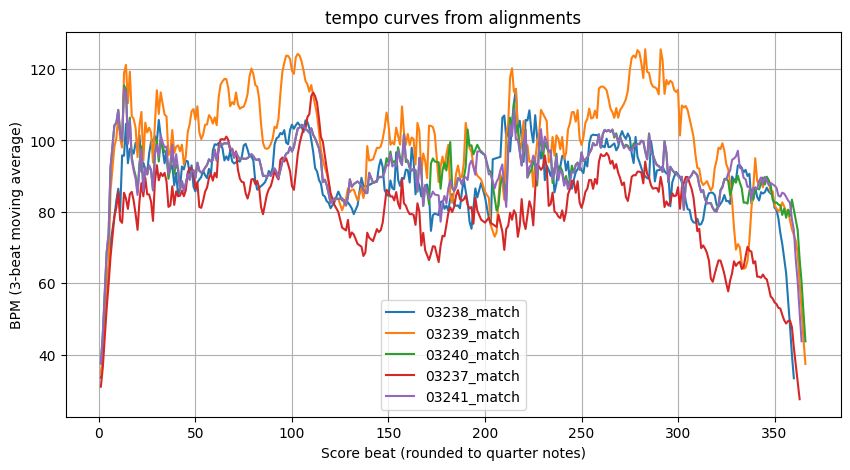

In [28]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

def tempo_curve(match_path: Path, fmt3x_path: Path, dt_min=0.05, bpm_range=(30,300), smooth_window=10):
    tpqn = 24.0
    m = re.search(r"TPQN:\s*(\d+)", fmt3x_path.read_text())
    if m:
        tpqn = float(m.group(1))

    rows = []
    for ln in match_path.read_text().splitlines():
        if not ln.strip() or ln.startswith("//") or ln.startswith("Missing"):
            continue
        parts = re.split(r"\s+", ln.strip())
        if len(parts) < 12:
            continue
        rows.append({"onset": float(parts[1]), "score_time": float(parts[8]), "score_note": parts[9], "err_idx": parts[10]})
    df = pd.DataFrame(rows)
    df = df[(df["score_note"] != "*") & (df["err_idx"] == "0")]
    if df.empty:
        return None

    df["score_beat"] = df["score_time"] / tpqn
    df["beat_bin"] = df["score_beat"].round()
    group = df.groupby("beat_bin")["onset"].median().sort_index()
    beats = group.index.to_numpy(); times = group.values
    if len(times) < 2:
        return None

    d_beat = np.diff(beats); d_time = np.diff(times)
    mask = (d_time > dt_min) & (d_beat > 1e-6)
    beats_mid = beats[1:][mask]; tempo = 60.0 * d_beat[mask] / d_time[mask]
    lo, hi = bpm_range
    tempo = tempo[(tempo > lo) & (tempo < hi)]
    beats_mid = beats_mid[:len(tempo)]
    if smooth_window and len(tempo) >= smooth_window:
        tempo = np.convolve(tempo, np.ones(smooth_window)/smooth_window, mode="same")
    return beats_mid, tempo

work_dir = Path("AlignmentTool/batch_pagodes")
fmt3x = work_dir / "score_fmt3x.txt"
match_files = [p for p in work_dir.glob("03*_match.txt") if "pre" not in p.name and "err" not in p.name]

plt.figure(figsize=(10,5))
for mf in match_files:
    res = tempo_curve(mf, fmt3x)
    if res is None:
        continue
    beats_mid, tempo = res
    plt.plot(beats_mid, tempo, label=mf.stem)

plt.xlabel("Score beat (rounded to quarter notes)")
plt.ylabel("BPM (3-beat moving average)")
plt.title("tempo curves from alignments")
plt.legend()
plt.grid(True)
plt.show()


In [1]:
from pathlib import Path
from collections import defaultdict

root = Path("/Users/toddywang/Documents/VsCodeProjects/xmltoexp/ATEPP-1.2/ATEPP-1.2")

def piece_key(p: Path):
    parts = p.relative_to(root).parts
    return parts[0], parts[1] if len(parts) > 1 else "<unknown>"

midi_cnt = defaultdict(int)
match_cnt = defaultdict(int)

# 统计 MIDI
for midi in root.rglob("*.mid"):
    midi_cnt[piece_key(midi)] += 1

# 只统计真正的 match，排除 pre/err
for mt in root.rglob("*_match.txt"):
    stem = mt.stem
    if stem.endswith("_pre_match") or stem.endswith("_err_match"):
        continue
    match_cnt[piece_key(mt)] += 1

total_midis = sum(midi_cnt.values())
total_matches = sum(match_cnt.values())

pieces_with_match = [(k, match_cnt[k], midi_cnt.get(k, 0)) for k in match_cnt if match_cnt[k] > 0]

print(f"总 MIDI 数: {total_midis}")
print(f"match 文件总数: {total_matches}")
print(f"有匹配的乐谱数: {len(pieces_with_match)}")

print("\nComposer/Piece: match数 / MIDI数")
for (comp, piece), m_match, m_midi in sorted(pieces_with_match):
    print(f"- {comp} / {piece}: {m_match} / {m_midi}")


总 MIDI 数: 11699
match 文件总数: 100
有匹配的乐谱数: 8

Composer/Piece: match数 / MIDI数
- Alexander_Scriabin / Piano_Sonata_No._5,_Op._53: 6 / 6
- Franz_Liszt / Mephisto_Waltz_No._1,_S.514: 20 / 20
- Maurice_Ravel / Jeux_d'eau,_M._30: 24 / 24
- Maurice_Ravel / La_valse,_M.72: 1 / 1
- Maurice_Ravel / Pavane_pour_une_infante_défunte,_M._19: 15 / 15
- Robert_Schumann / Abegg_Variations,_Op._1: 7 / 7
- Robert_Schumann / Arabeske,_Op._18: 11 / 11
- Robert_Schumann / Toccata_in_C_Major,_Op._7: 16 / 20


In [9]:
import pandas as pd
from collections import defaultdict
from pathlib import Path

root = Path("/Users/toddywang/Documents/VsCodeProjects/xmltoexp/ATEPP-1.2/ATEPP-1.2")

# perf_id -> 细节
meta = pd.read_csv("/Users/toddywang/Documents/VsCodeProjects/xmltoexp/ATEPP-master/ATEPP-metadata-1.2.csv")
perf_info = (
    meta[["perf_id", "artist_id", "artist", "composer", "track"]]
    .drop_duplicates(subset=["perf_id"])
    .set_index("perf_id")
    .to_dict("index")
)

matches = []
for mt in root.rglob("*_match.txt"):
    st = mt.stem
    if st.endswith("_pre_match") or st.endswith("_err_match"):
        continue
    matches.append(mt)

# 演奏家 -> 已匹配曲目列表
performer_to_tracks = defaultdict(list)

for mt in matches:
    perf_id = mt.stem.replace("_match", "")
    info = perf_info.get(perf_id)
    if info is None:
        continue  # 找不到 metadata 就跳过
    artist_key = (info["artist_id"], info["artist"])
    track_full = f"{info['composer']} - {info['track']}"
    performer_to_tracks[artist_key].append(track_full)

print(f"已有匹配的演奏数: {len(matches)}")
print(f"涉及演奏家数: {len(performer_to_tracks)}\n")

print("演奏家及其在已匹配乐谱中的曲目：")
for (artist_id, artist), tracks in sorted(performer_to_tracks.items()):
    uniq = sorted(set(tracks))
    print(f"- id={artist_id} {artist}: {len(uniq)} 首")
    for t in uniq:
        print(f"  · {t}")


已有匹配的演奏数: 100
涉及演奏家数: 27

演奏家及其在已匹配乐谱中的曲目：
- id=0 Sviatoslav Richter: 11 首
  · Alexander Scriabin - Piano Sonata No. 5, Op. 53
  · Alexander Scriabin - Piano Sonata No. 5, Op. 53 (Live)
  · Franz Liszt - Der Tanz in der Dorfschenke, S514/R181, "Mephisto Waltz No. 1"
  · Maurice Ravel - Jeux d'eau, M. 30
  · Maurice Ravel - Jeux d'eau, M. 30 (Live)
  · Maurice Ravel - Pavane pour une infante défunte, M. 19
  · Maurice Ravel - Pavane pour une infante défunte, M. 19 (Live)
  · Robert Schumann - Abegg Variations, Op. 1 - Live
  · Robert Schumann - Abegg Variations, Op.1 - Live
  · Robert Schumann - Toccata in C Major, Op. 7
  · Robert Schumann - Toccata in C Major, Op. 7: Allegro
- id=1 Emil Gilels: 3 首
  · Maurice Ravel - Jeux d'eau, M. 30 (Live)
  · Maurice Ravel - Pavane pour une infante defunte, M. 19 (Version for Piano)
  · Robert Schumann - Toccata in C Major, Op. 7 (Live)
- id=2 Vladimir Horowitz: 11 首
  · Alexander Scriabin - Piano Sonata No. 5, Op. 53
  · Alexander Scriabin - Sona

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import re

piece_dir = Path("/Users/toddywang/Documents/VsCodeProjects/xmltoexp/ATEPP-1.2/ATEPP-1.2/Franz_Liszt/Mephisto_Waltz_No._1,_S.514")
fmt3x = piece_dir / "score_fmt3x.txt"
match_files = sorted(
    p for p in piece_dir.glob("*_match.txt")
    if not p.stem.endswith(("_pre_match", "_err_match"))
)

def bpm_curve(match_path: Path, fmt3x_path: Path, bpm_range=(30, 300), window=3):
    # 读 TPQN
    tpqn = 24.0
    m = re.search(r"TPQN:\s*(\d+)", fmt3x_path.read_text())
    if m:
        tpqn = float(m.group(1))

    rows = []
    for ln in match_path.read_text().splitlines():
        if not ln.strip() or ln.startswith("//") or ln.startswith("Missing"):
            continue
        parts = re.split(r"\s+", ln.strip())
        if len(parts) < 12:
            continue
        rows.append({
            "onset": float(parts[1]),
            "score_time": float(parts[8]),
            "score_note": parts[9],
            "err_idx": parts[10],
        })
    if not rows:
        return None

    df = pd.DataFrame(rows)
    df["score_beat"] = df["score_time"] / tpqn
    # 只保留正常匹配
    df = df[(df["score_note"] != "*") & (df["err_idx"] == "0")]
    if df.empty:
        return None

    # 每拍取 onset 中位数，并补齐缺失拍（用前后线性平均）
    beat_time = df.groupby(df["score_beat"].round())["onset"].median().sort_index()
    full_idx = pd.Index(range(int(beat_time.index.min()), int(beat_time.index.max()) + 1))
    beat_time = beat_time.reindex(full_idx)
    beat_time = beat_time.interpolate("linear")  # 缺失拍用前后平均

    # 逐拍 tempo（当前拍与前一拍的间隔）+ 滑动平均
    dt = beat_time.diff()
    tempo = 60.0 / dt
    tempo = tempo.dropna()
    lo, hi = bpm_range
    tempo = tempo[(tempo > lo) & (tempo < hi)]
    tempo = tempo.rolling(window=window, center=True, min_periods=1).mean()
    tempo = tempo.clip(upper=600)
    return tempo

print(f"发现 {len(match_files)} 个 match 文件")
all_tempos = {}

for mf in match_files:
    tempo = bpm_curve(mf, fmt3x)
    if tempo is None or tempo.empty:
        print(mf.name, "无有效 BPM")
        continue
    all_tempos[mf.name] = tempo
    print(f"{mf.name}: {len(tempo)} 拍，BPM min/med/max="
          f"{tempo.min():.1f}/{tempo.median():.1f}/{tempo.max():.1f}")
    print("  头5个 BPM:", np.round(tempo.head(5).to_numpy(), 2))

# 平滑后的曲线存成 numpy 数组字典
tempo_arrays = {name: t.to_numpy() for name, t in all_tempos.items()}
print("已存入 tempo_arrays，包含", len(tempo_arrays), "条曲线")


# 将各曲线补齐到相同长度（缺失拍用前后平均插值），得到等长 numpy 数组
if all_tempos:
    max_len = max(len(t) for t in all_tempos.values())
    tempo_arrays_equalized = {}
    for name, t in all_tempos.items():
        # 先对齐到统一索引，再线性插值（相当于用前后平均），最后用前/后值补足两端
        t_eq = t.reindex(range(max_len))
        t_eq = t_eq.interpolate(method='linear', limit_direction='both')
        t_eq = t_eq.fillna(method='ffill').fillna(method='bfill')
        tempo_arrays_equalized[name] = t_eq.to_numpy()
    print('已生成等长 tempo_arrays_equalized，长度', max_len, '，条数', len(tempo_arrays_equalized))
else:
    tempo_arrays_equalized = {}


发现 20 个 match 文件
10456_match.txt: 1370 拍，BPM min/med/max=30.7/174.4/299.2
  头5个 BPM: [139.21  96.1   94.81 134.54 210.41]
10457_match.txt: 1362 拍，BPM min/med/max=34.4/142.8/299.2
  头5个 BPM: [ 60.51  60.51 190.41 157.81 258.15]
10458_match.txt: 1356 拍，BPM min/med/max=31.1/143.1/297.3
  头5个 BPM: [ 36.24 185.81 192.   188.85 199.91]
10459_match.txt: 1349 拍，BPM min/med/max=31.5/141.8/299.2
  头5个 BPM: [ 60.51  60.51 191.6  187.7  197.77]
10460_match.txt: 1372 拍，BPM min/med/max=30.4/144.1/299.2
  头5个 BPM: [ 34.79 180.71 182.5  176.21 194.02]
10461_match.txt: 1353 拍，BPM min/med/max=32.4/139.4/294.4
  头5个 BPM: [153.6   82.14 163.99  54.92 157.81]
10462_match.txt: 1373 拍，BPM min/med/max=31.9/175.5/290.7
  头5个 BPM: [ 50.01  50.01 120.31 208.51 225.88]
10463_match.txt: 1393 拍，BPM min/med/max=31.1/162.8/298.3
  头5个 BPM: [ 46.79  46.79 206.17 201.66 197.77]
10464_match.txt: 1399 拍，BPM min/med/max=31.3/164.9/297.3
  头5个 BPM: [ 54.69  54.69 203.   205.71 195.25]
10465_match.txt: 1419 拍，BPM min/med/ma

匹配文件数: 20


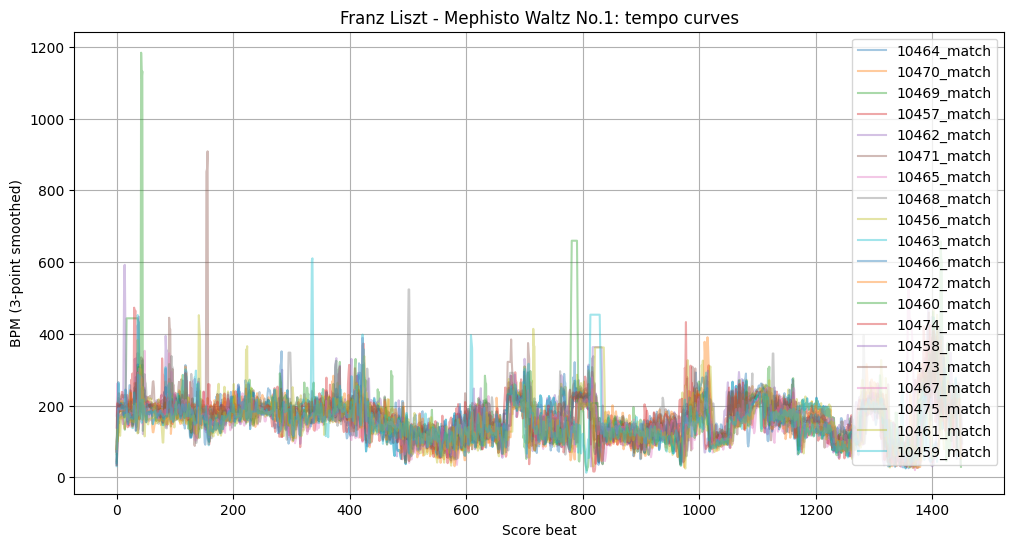

In [ ]:
import matplotlib.pyplot as plt

print(f"匹配文件数: {len(all_tempos)}")
plt.figure(figsize=(12, 6))

for name, tempo in all_tempos.items():  # tempo 是平滑后的 Series
    beats = tempo.index.to_numpy()
    vals = tempo.to_numpy()
    plt.plot(beats, vals, label=name.replace("_match.txt", ""), alpha=0.4)

plt.xlabel("Beat index")
plt.ylabel("Tempo (BPM, smoothed)")
plt.title("Franz Liszt - Mephisto Waltz No.1: tempo curves (all matches)")
plt.legend(loc="upper right", fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [5]:
from pathlib import Path
import sys
import pandas as pd
from dataclasses import asdict

# 路径设置
repo_root = Path("/Users/toddywang/Documents/VsCodeProjects/xmltoexp")
tok_root = repo_root / "MERIX SUBMISSION/MIREX_Model/MIREX_Tokenizer"
sys.path.insert(0, str(tok_root))  # 让 tokenizer 模块可导入

# 目标乐谱（score）
score_path = repo_root / "ATEPP-1.2/ATEPP-1.2/Franz_Liszt/Mephisto_Waltz_No._1,_S.514/musicxml_cleaned.musicxml"

from tokenizer.score_tokenizer import MusicXMLTokenizer

# 解析 score
tok = MusicXMLTokenizer(str(score_path))
score_notes = tok.tokenize_notes()      # ScoreNoteToken 列表
score_exprs = tok.parse_expressions()   # ScoreExpression 列表
score_meta  = tok.parse_metadata()      # ScoreMetadata

print("Metadata:", score_meta)
print(f"Notes: {len(score_notes)}, Expressions: {len(score_exprs)}")

# 转成 DataFrame 便于查看/统计
df_notes = pd.DataFrame([asdict(n) for n in score_notes])
df_exprs = pd.DataFrame([asdict(e) for e in score_exprs]) if score_exprs else pd.DataFrame()

# 基本预览
print("\n前 5 个音符：")
display(df_notes.head())

print("\n奏法标记计数（staccato/accent/tie）：")
print(df_notes[["is_staccato", "is_accent", "tie"]].value_counts())

print("\nPitch 统计：")
print(df_notes["pitch"].value_counts().head(10))

print("\n起拍/时值范围：")
print(df_notes[["position", "duration"]].agg(["min", "max", "mean"]))

if not df_exprs.empty:
    print("\n表达式类型计数：")
    print(df_exprs["type"].value_counts())
    print("\n前 5 个表达式：")
    display(df_exprs.head())
else:
    print("\n无解析出的表达式记录")


Metadata: ScoreMetadata(composer=None, genre=None, major_time_sig='3/8', year=None, title='Mephisto Waltz No. 1 S. 514')
Notes: 10240, Expressions: 754

前 5 个音符：


,pitch,duration,position,part_id,tie,is_staccato,is_accent,fingering,xml_note_id
0,E#3,0.0,13.5,P1-Staff1,None,False,False,None,None
1,F#3,0.5,13.5,P1-Staff1,None,False,True,None,None
2,F#3,0.5,14.0,P1-Staff1,None,False,False,None,None
3,F#3,0.5,14.5,P1-Staff1,None,False,False,None,None
4,F#3,0.5,15.0,P1-Staff1,None,False,False,None,None



奏法标记计数（staccato/accent/tie）：
is_staccato  is_accent  tie     
False        False      start       70
                        stop        58
True         False      stop        16
False        False      continue     7
             True       start        4
Name: count, dtype: int64

Pitch 统计：
pitch
A3     399
E4     348
C#4    309
D4     303
E5     269
F#3    248
E2     247
E6     246
A4     236
E3     232
Name: count, dtype: int64

起拍/时值范围：
         position  duration
min      1.500000  0.000000
max   1456.485417  2.000000
mean   750.660933  0.441325

表达式类型计数：
type
slur_start    538
velocity      163
tie            53
Name: count, dtype: int64

前 5 个表达式：


,text,type,absolute_onset_in_beats,duration,data_value
0,mf,velocity,1.5,0.0,None
1,slur_5915209648,slur_start,1.5,0.0,None
2,slur_5921552512,slur_start,4.5,0.0,None
3,slur_5914264576,slur_start,6.0,0.0,None
4,slur_5914266352,slur_start,7.5,0.0,None


In [4]:
%pip install music21


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/58/7e/78ba6e26ba2d9c30d39761ce43076d438a47577001f92bc43a46d485df9d/music21-9.9.1-py3-none-any.whl (20.1 MB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/38/6f/f5fbc992a329ee4e0f288c1fe0e2ad9485ed064cac731ed2fe47dcc38cbf/chardet-5.2.0-py3-none-any.whl (199 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/c1/73/04df8a6fa66d43a9fd45c30f283cc4afff17da671886e451d52af60bdc7e/jsonpickle-4.1.1-py3-none-any.whl (47 kB)
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/a4/8e/469e5a4a2f5855992e425f3cb33804cc07bf18d48f2db061aec61ce50270/more_itertools-10.8.0-py3-none-any.whl (69 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [music21]m4/5 [music21]
Note: you may need to restart the kernel to use updated packages.


In [10]:
import sys, torch
from pathlib import Path
from dataclasses import asdict

# 路径设定
repo_root = Path("/Users/toddywang/Documents/VsCodeProjects/xmltoexp")
tok_root  = repo_root / "MERIX SUBMISSION/MIREX_Model/MIREX_Tokenizer"
sys.path.insert(0, str(tok_root))
sys.path.insert(0, str(repo_root / "MERIX SUBMISSION/MIREX_Model"))  # 为导入 PitchDecomposer

from tokenizer.score_tokenizer import MusicXMLTokenizer
from dataset import PitchDecomposer  # 项目里的分解音高工具

# 读取乐谱
score_path = repo_root / "ATEPP-1.2/ATEPP-1.2/Franz_Liszt/Mephisto_Waltz_No._1,_S.514/musicxml_cleaned.musicxml"
tok = MusicXMLTokenizer(str(score_path))
score_notes = tok.tokenize_notes()

# 初始化工具
decomposer = PitchDecomposer()

# 构造张量：顺序 [note_idx, accidental_idx, octave_idx, position, duration, is_staccato, is_accent, part_id]
features = []
for sn in score_notes:
    d = asdict(sn)
    note_idx, acc_idx, oct_idx = decomposer.parse_pitch(d["pitch"])
    position = float(d["position"])
    duration = float(d["duration"])
    is_staccato = 1 if d.get("is_staccato", False) else 0
    is_accent   = 1 if d.get("is_accent", False) else 0
    # part_id: 右手/左手（Staff1/Staff2），没有则默认 0
    part_id_str = d.get("part_id", "P1-Staff1")
    part_id = 0 if "Staff1" in part_id_str else 1

    features.append([
        note_idx,
        acc_idx,
        oct_idx,
        position,
        duration,
        is_staccato,
        is_accent,
        part_id,
    ])

score_tensor = torch.tensor(features, dtype=torch.float32).unsqueeze(0)  # [1, seq_len, 8]
print("score_tensor shape:", score_tensor.shape)
print("前两行示例：\n", score_tensor[0, :2])



score_tensor shape: torch.Size([1, 10240, 8])
前两行示例：
 tensor([[ 2.0000,  3.0000,  4.0000, 13.5000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 3.0000,  3.0000,  4.0000, 13.5000,  0.5000,  0.0000,  1.0000,  0.0000]])
